In [19]:
import sys
sys.path.insert(0,'/home/alan/code/MarvinLiebisch/forecasting-electricity-prices')

In [20]:
sys.path

['/home/alan/code/MarvinLiebisch/forecasting-electricity-prices',
 '/home/alan/code/MarvinLiebisch/forecasting-electricity-prices',
 '/home/alan/code/MarvinLiebisch/forecasting-electricity-prices/notebook',
 '/home/alan/code/AlanLHO/data-context-and-setup',
 '/home/alan/code/MarvinLiebisch/forecasting-electricity-prices/notebook',
 '/home/alan/.pyenv/versions/3.10.6/lib/python310.zip',
 '/home/alan/.pyenv/versions/3.10.6/lib/python3.10',
 '/home/alan/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload',
 '',
 '/home/alan/.pyenv/versions/3.10.6/envs/forecasting-electricity-prices/lib/python3.10/site-packages']

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU,Dense
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from data_import import import_merged_data
from preprocessing_basic import run_pipeline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import random
from tensorflow.keras.optimizers import Nadam

To use the RNN model,we need a lot of sequence. To do so, because we have only one serie to predict, We have to cut our input in multiple sequence. We can choose sequence of one month. 
Indeed, the input of RNN have this dimension : (n_squence, n_observation, n_feature)
The length of the sequence will have an impact on the seasonality capturing. 

The units in RNN add feature which store the context from previous input

We have to tried RNN,LSTM, GRU and maybe take a look at the bidirectional RNN

In [22]:
X=import_merged_data().drop(columns=['price_actual'])
y=X[['price_day_ahead']]
X=pd.DataFrame(run_pipeline(X, max_categories = 10, treat_remainder = 'drop'))

Importing energy_dataset data from /home/alan/code/MarvinLiebisch/forecasting-electricity-prices/raw_data/energy_dataset.csv...
Importing weather_features data from /home/alan/code/MarvinLiebisch/forecasting-electricity-prices/raw_data/weather_features.csv...


In [23]:
y.shape,X.shape

((38522, 1), (38522, 119))

In [24]:
def sequence_data(X, y, 
                  n_observation_X, n_observation_y,
                  n_sequence_train,n_sequence_val,n_sequence_test,
                  val_cutoff,test_cutoff):
    
    
    sample_list_train = list(range(0, int(len(X)-n_observation_y-n_observation_X)))
    sample_list_val = list(range(int(len(X)*val_cutoff),int(len(X)*test_cutoff)))
    sample_list_test= list(range(int(len(X)*test_cutoff),int(len(X)-n_observation_y-n_observation_X)))
    
    random.shuffle(sample_list_train)
    random.shuffle(sample_list_val)
    random.shuffle(sample_list_test)
    
    X_train=np.zeros((n_sequence_train, n_observation_X, X.shape[1]))
    X_val=np.zeros((n_sequence_val, n_observation_X, X.shape[1]))
    X_test=np.zeros((n_sequence_test, n_observation_X, X.shape[1]))
    
    y_train=np.zeros((n_sequence_train, n_observation_y, 1))
    y_val=np.zeros((n_sequence_val, n_observation_y, 1))
    y_test=np.zeros((n_sequence_test, n_observation_y, 1))
    
    
    def create_sequence(X_,y_,sample_list):
        index=0
        for i in sample_list:
            X_[index] = X.iloc[i:i + n_observation_X].values
            y_[index]= y.iloc[i + n_observation_X:i + n_observation_X + n_observation_y].values
        return X_, y_
    
    X_train, y_train = create_sequence(X_train,y_train,sample_list_train)
    X_val, y_val = create_sequence(X_val,y_val,sample_list_val)
    X_test, y_test = create_sequence(X_test,y_test,sample_list_test)
    
    return X_train, X_val, X_test, y_train, y_val,y_test


n_observation_X=24 * 7  # For example, a week of data for the sequence
n_observation_y=24 # We would like to forecast the 24 prices of the next day during the auction of today
n_sequence_train=1000
n_sequence_val=50
n_sequence_test=20
val_cutoff=0.8
test_cutoff=0.9


In [25]:
24 * 7  

168

In [26]:
X_train, X_val, X_test, y_train, y_val,y_test = sequence_data(X, y, 
                  n_observation_X, n_observation_y,
                  n_sequence_train,n_sequence_val,n_sequence_test,
                  val_cutoff,test_cutoff)

In [27]:
'''def create_sequences(X, y, observation_length,step):
    n_SEQUENCES=len(range(0,len(X) - observation_length - 24,step))
    X_sequenced = np.zeros((n_SEQUENCES, observation_length, X.shape[1])) # initialize the dataframe with the new sequences
    y_sequenced= np.zeros((n_SEQUENCES, step,1))
    index=0
    for i in range(len(X) - observation_length - 24,0,-step):
        X_sequenced[index] = X.iloc[i:i + observation_length].values
        y_sequenced[index]= y.iloc[i + observation_length:i + observation_length + 24].values
        index=index+1
    return X_sequenced, y_sequenced
step=24
observation_length = 24 * 7  # For example, a week of data for the sequence
X_sequenced, y_sequenced = create_sequences(X, y, observation_length,step)'''

'def create_sequences(X, y, observation_length,step):\n    n_SEQUENCES=len(range(0,len(X) - observation_length - 24,step))\n    X_sequenced = np.zeros((n_SEQUENCES, observation_length, X.shape[1])) # initialize the dataframe with the new sequences\n    y_sequenced= np.zeros((n_SEQUENCES, step,1))\n    index=0\n    for i in range(len(X) - observation_length - 24,0,-step):\n        X_sequenced[index] = X.iloc[i:i + observation_length].values\n        y_sequenced[index]= y.iloc[i + observation_length:i + observation_length + 24].values\n        index=index+1\n    return X_sequenced, y_sequenced\nstep=24\nobservation_length = 24 * 7  # For example, a week of data for the sequence\nX_sequenced, y_sequenced = create_sequences(X, y, observation_length,step)'

In [28]:
'''X_train, X_test, y_train, y_test = train_test_split(X_sequenced, y_sequenced, test_size=0.2, random_state=42, shuffle=True)'''

'X_train, X_test, y_train, y_test = train_test_split(X_sequenced, y_sequenced, test_size=0.2, random_state=42, shuffle=True)'

In [29]:
# Baseline model

y_train_flaten=np.reshape(y_train,(-1, 1))
y_true_baseline= pd.DataFrame(y_train_flaten, columns=['y_train'])[24:]
y_pred_baseline= pd.DataFrame(y_train_flaten, columns=['y_train']).shift(24).dropna()

print(f"MAE: {round(mean_absolute_error(y_true_baseline, y_pred_baseline),2)} and the mean of day ahead price is : {round(y_true_baseline.mean()[0],2)}")

MAE: 0.06 and the mean of day ahead price is : 0.0


In [30]:
model = Sequential()
model.add(LSTM(units=64, input_shape=X_train.shape[1:], return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(y.shape[1], activation='linear'))  # Output layer with 24 neurons (one for each hour)

# Compile and train the model
initial_learning=0.01 # Default value is 0.001
optimizer = Nadam(lr=initial_learning) #change the optimizer and right all the default value
model.compile(optimizer=optimizer, loss='mse',metrics=['mae'])
es = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history =model.fit(X_train, y_train, epochs=1000, batch_size=16, callbacks=[es], validation_data=(X_val,y_val),verbose=1,shuffle=False)

2023-03-23 14:26:23.851196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-23 14:26:23.919926: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 14:26:23.936789: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-JV7MDF9): /proc/driver/nvidia/version does not exist
2023-03-23 14:26:24.229219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/alan/.pyenv/versions/3.10.6/envs/forecasting-electricity-prices/lib/python3.10/site-packages/keras/op

Epoch 1/1000
63/63 [==============================] - 219s 2s/step - loss: 3.8631 - mae: 0.0726 - val_loss: 71.9440 - val_mae: 1.1993
Epoch 2/1000
63/63 [==============================] - 97s 2s/step - loss: 4.4424 - mae: 0.3229 - val_loss: 72.8316 - val_mae: 1.2066
Epoch 3/1000
63/63 [==============================] - 101s 2s/step - loss: 3.5411 - mae: 0.0599 - val_loss: 69.0729 - val_mae: 1.1751
Epoch 4/1000
63/63 [==============================] - 109s 2s/step - loss: 3.3578 - mae: 0.0723 - val_loss: 65.4978 - val_mae: 1.1442
Epoch 5/1000
63/63 [==============================] - 178s 3s/step - loss: 3.1834 - mae: 0.0797 - val_loss: 61.5568 - val_mae: 1.1092
Epoch 6/1000
35/63 [===============>..............] - ETA: 55s - loss: 5.3403 - mae: 0.1448

In [ ]:
def plt_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

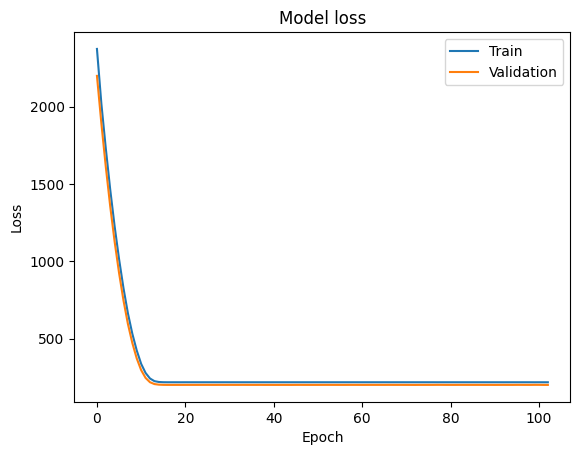

In [ ]:
plt_history(history)

In [ ]:
model.save('mon_modele_1.h5')